Largest circle:
Center: (110, 258)
Radius: 15
Sigma: 2.0


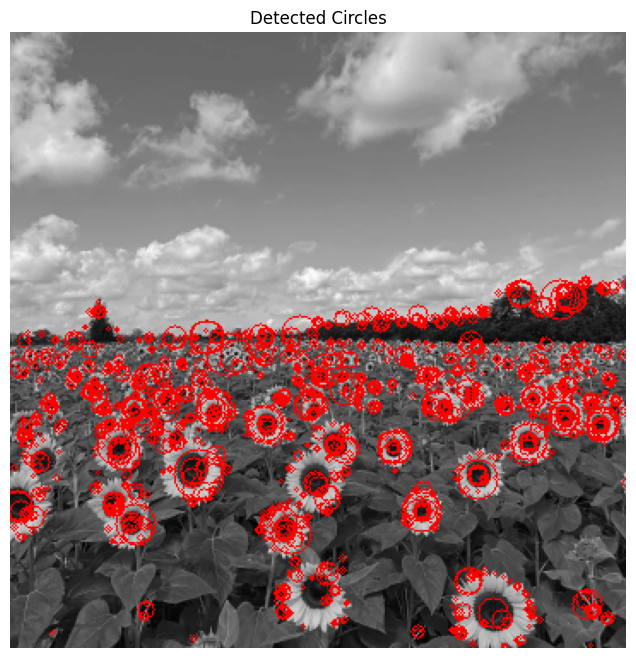

In [8]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

img = cv.imread(r'C:\Users\MSII\Documents\sem 5\image processing\Assignment 2\the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)
gray_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# parameters for scale-space extrema detection
min_sigma = 0.5  
max_sigma = 2.0  
num = 7 
threshold = 0.35  
circles = []

for sigma in np.linspace(min_sigma, max_sigma, num):

    laplacian = cv.Laplacian(cv.GaussianBlur(gray_img, (0, 0), sigma), cv.CV_64F)   #cv.CV_64F - output format, sigma - std
    laplacian = np.abs(laplacian)
    blob = laplacian > threshold * laplacian.max()

    # Find contours in the blob mask
    contours, _ = cv.findContours(blob.astype(np.uint8), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # Loop through the detected contours and fit circles to them
    for cont in contours:
        if len(cont) >= 5:
            (x, y), radius = cv.minEnclosingCircle(cont)
            center = (int(x), int(y))
            radius = int(radius)
            circles.append((center, radius, sigma))
circles.sort(key=lambda x: -x[1])
circle_max = circles[0]
center, radius, sigma = circle_max

print("Largest circle:")
print(f"Center: {center}")
print(f"Radius: {radius}")
print(f"Sigma: {sigma}")

output_img = cv.cvtColor(gray_img, cv.COLOR_GRAY2BGR)
for circle in circles:
    center, radius, _ = circle
    cv.circle(output_img, center, radius, (0, 0, 255), 1)

# Display the grayscale image with detected circles using matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(cv.cvtColor(output_img, cv.COLOR_BGR2RGB),cmap='gray')
plt.axis('off')
plt.title('Circles')
plt.show()



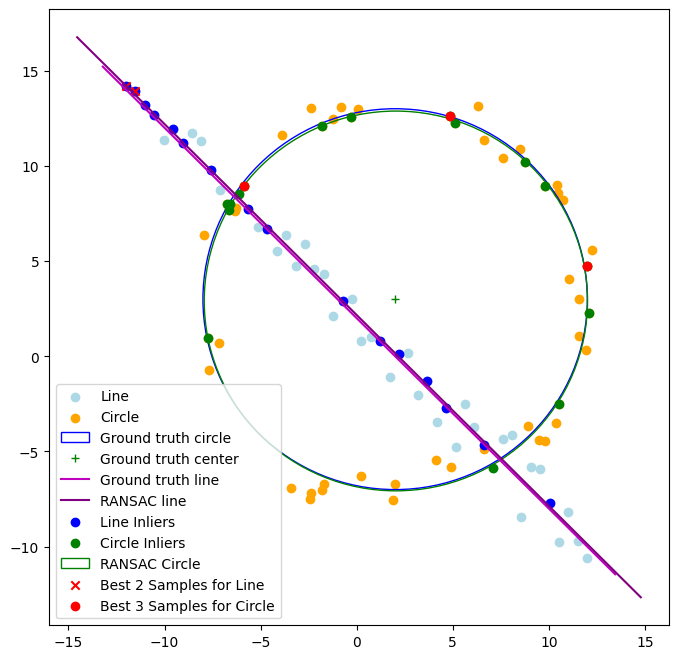

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.optimize import minimize

import numpy as np
import matplotlib.pyplot as plt

# Seed for reproducibility
np.random.seed(1)

N = 100
half_n = N // 2
r = 10
x0_gt, y0_gt = 2, 3  # Center of the circle
s = r / 16

# Generate points for the circle
theta = np.random.uniform(0, 2 * np.pi, half_n)
noise = s * np.random.randn(half_n)
x_circle = x0_gt + (r + noise) * np.cos(theta)
y_circle = y0_gt + (r + noise) * np.sin(theta)

X_circ = np.column_stack((x_circle, y_circle))

# Generate points for the line
s = 1.0
m, b = -1, 2

x_line = np.linspace(-12, 12, half_n)
y_line = m * x_line + b + s * np.random.randn(half_n)

X_line = np.column_stack((x_line, y_line))

# Concatenate points from both circle and line to create X
X = np.vstack((X_circ, X_line))

# Plot the noisy points, ground truth line, and ground truth circle
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_line[:, 0], X_line[:, 1], color = 'lightblue', label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], color = 'orange', label='Circle')
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='blue', fill=False, label='Ground truth circle')
ax.add_artist(circle_gt)
ax.plot(x0_gt, y0_gt, '+g', label='Ground truth center')
x_min, x_max = ax.get_xlim()
x_range = np.array([x_min, x_max])
y_range = m * x_range + b
plt.plot(x_range, y_range, color='m', label='Ground truth line')



# Define a function to calculate the line equation from two points
def line_equation_from_points(x1, y1, x2, y2):
    delta_x = x2 - x1
    delta_y = y2 - y1
    magnitude = math.sqrt(delta_x**2 + delta_y**2)
    a = delta_y / magnitude
    b = -delta_x / magnitude
    d = (a * x1) + (b * y1)
    return a, b, d

# RANSAC to fit a line with unit normal constraint
def ransac_line(X, iterations, threshold, min_inliers):
    best_model = None
    best_inliers = []
    
    for _ in range(iterations):
        sample_indices = np.random.choice(len(X), 2, replace=False)
        x1, y1 = X[sample_indices[0]]
        x2, y2 = X[sample_indices[1]]
        
        a, b, d = line_equation_from_points(x1, y1, x2, y2)
        
        # Constraint: Ensure unit normal vector
        magnitude = np.sqrt(a**2 + b**2)
        a /= magnitude
        b /= magnitude
        
        # Calculate the distance of all points to the line
        distances = np.abs(a*X[:,0] + b*X[:,1] - d)
        
        # Find inliers based on the threshold
        inliers = np.where(distances < threshold)[0]
        
        if len(inliers) >= min_inliers:
            if len(inliers) > len(best_inliers):
                best_model = (a, b, d)
                best_inliers = inliers
                
    return best_model, best_inliers

# RANSAC parameters
iterations = 10000
threshold = 0.15
min_inliers = 15

# Estimate the line using RANSAC
best_line_model, Line_inlier_indices = ransac_line(X_line, iterations, threshold, min_inliers)

# Define a function to calculate the circle equation from three points
def circle_equation_from_points(x1, y1, x2, y2, x3, y3):
    # Calculate the midpoints of two line segments
    mx1, my1 = (x1 + x2) / 2, (y1 + y2) / 2
    mx2, my2 = (x2 + x3) / 2, (y2 + y3) / 2
    
    # Calculate the slopes of the two lines
    if y2 - y1 == 0:
        slope1 = 0  # Avoid division by zero
    else:
        slope1 = (x2 - x1) / (y2 - y1)
    
    if y3 - y2 == 0:
        slope2 = 0  # Avoid division by zero
    else:
        slope2 = (x3 - x2) / (y3 - y2)
    
    # Calculate the center of the circle
    x_center = (slope1 * mx1 - slope2 * mx2 + my2 - my1) / (slope1 - slope2)
    y_center = -slope1 * (x_center - mx1) + my1
    
    # Calculate the radius
    radius = np.sqrt((x1 - x_center)**2 + (y1 - y_center)**2)
    
    return x_center, y_center, radius

# RANSAC to fit a circle
def ransac_circle(X, iterations, threshold, min_inliers):
    best_model = None
    best_inliers = []
    
    for _ in range(iterations):
        sample_indices = np.random.choice(len(X), 3, replace=False)
        x1, y1 = X[sample_indices[0]]
        x2, y2 = X[sample_indices[1]]
        x3, y3 = X[sample_indices[2]]
        
        x_center, y_center, radius = circle_equation_from_points(x1, y1, x2, y2, x3, y3)
        
        # Calculate the radial error of all points to the circle
        errors = np.abs(np.sqrt((X[:, 0] - x_center)**2 + (X[:, 1] - y_center)**2) - radius)
        
        # Find inliers based on the threshold
        inliers = np.where(errors < threshold)[0]
        
        if len(inliers) >= min_inliers:
            if len(inliers) > len(best_inliers):
                best_model = (x_center, y_center, radius)
                best_inliers = inliers
                
    return best_model, best_inliers

# RANSAC parameters for circle estimation
circle_iterations = 10000
circle_threshold = 0.2  # Adjust the threshold as needed
circle_min_inliers = 15

# Identify the remnant points (not explained by the line)
remnant_indices = [i for i in range(len(X)) if i not in Line_inlier_indices]
remnant_points = X[remnant_indices]

# Estimate the circle using RANSAC
best_circle_model, circle_inlier_indices = ransac_circle(remnant_points, circle_iterations, circle_threshold, circle_min_inliers)


# Plot the results

# Plot the estimated line
x_min, x_max = ax.get_xlim()
x_range = np.array([x_min, x_max])
y_range = (-best_line_model[0] * x_range + best_line_model[2]) / best_line_model[1]
plt.plot(x_range, y_range, label='RANSAC line', color='purple')


ax.scatter(X_line[Line_inlier_indices, 0], X_line[Line_inlier_indices, 1], color='blue', label='Line Inliers')


# Find the best 2 samples for the line
best_line_sample_indices = Line_inlier_indices[:2]
best_line_samples = X_line[best_line_sample_indices]


# Plot the inliers of the circle
ax.scatter(remnant_points[circle_inlier_indices, 0], remnant_points[circle_inlier_indices, 1], color='g', label='Circle Inliers')

# Plot the estimated circle
x_center, y_center, radius = best_circle_model
circle_estimated = plt.Circle((x_center, y_center), radius, color='g', fill=False, label='RANSAC Circle')
ax.add_artist(circle_estimated)

# Find the best 3 samples for the circle (using circle_inlier_indices)
best_circle_sample_indices = circle_inlier_indices[:3]
best_circle_samples = remnant_points[best_circle_sample_indices]


# Plot the best 2 samples for the line and the best 3 samples for the circle
ax.scatter(best_line_samples[:, 0], best_line_samples[:, 1], color='red', marker='x', label='Best 2 Samples for Line')
ax.scatter(best_circle_samples[:, 0], best_circle_samples[:, 1], color='red', marker='o', label='Best 3 Samples for Circle')


plt.legend()
plt.show()



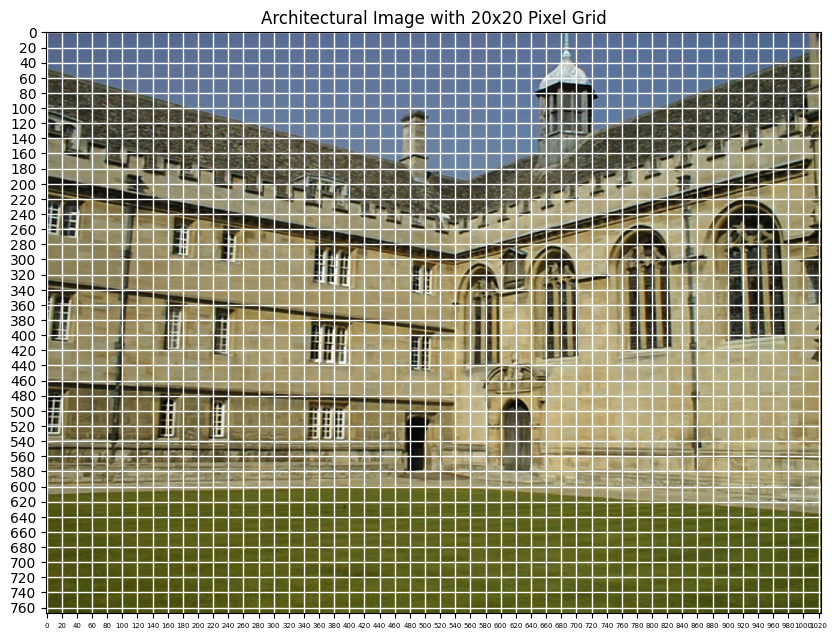

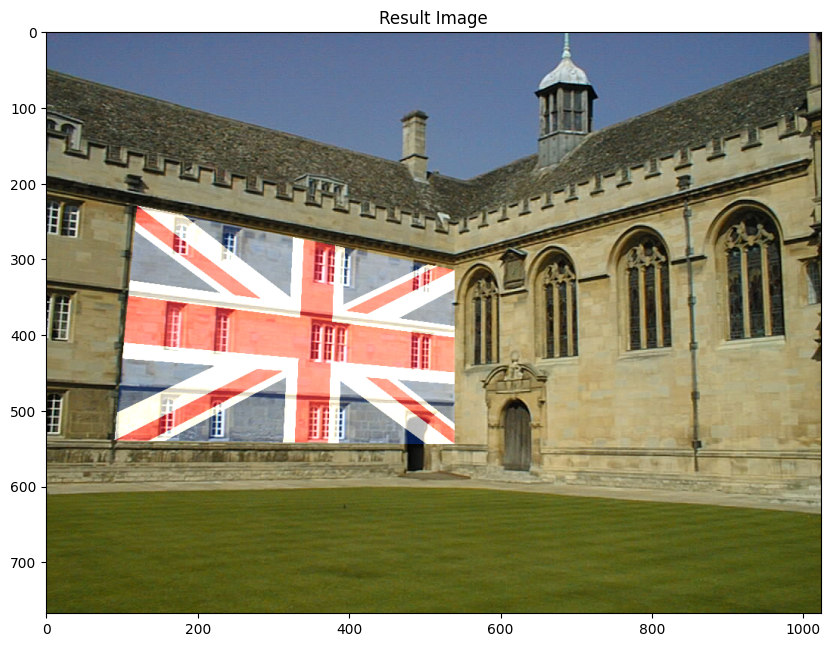

In [68]:
import cv
import numpy as np
import matplotlib.pyplot as plt

# Load the architectural image and the flag image
architectural_image = cv.imread('architectural_image.jpg')
flag_image = cv.imread('flag_image.png')

# Display the architectural image with a 20x20 pixel grid
plt.figure(figsize=(10, 10))
plt.imshow(cv.cvtColor(architectural_image, cv.COLOR_BGR2RGB))
plt.xticks(np.arange(0, architectural_image.shape[1], 20), fontsize=5)
plt.yticks(np.arange(0, architectural_image.shape[0], 20))
plt.grid(True, color='white', linewidth=1)
plt.title('Architectural Image with 20x20 Pixel Grid')
plt.show()

# Define the four points on the architectural image that form a planar surface
# Replace these with the actual coordinates
points_on_architecture = np.array([[120, 230], [540, 315], [540, 545], [90, 540]], dtype=np.float32)

# Define the corresponding points on the flag image (in the same order)
points_on_flag = np.array([[0, 0], [flag_image.shape[1], 0], [flag_image.shape[1], flag_image.shape[0]], [0, flag_image.shape[0]]], dtype=np.float32)

# Compute the homography matrix
homography_matrix, _ = cv.findHomography(points_on_flag, points_on_architecture)

# Warp the flag image onto the architectural image using the homography
flag_warped = cv.warpPerspective(flag_image, homography_matrix, (architectural_image.shape[1], architectural_image.shape[0]))

# Blend the warped flag image with the architectural image
result_image = cv.addWeighted(architectural_image, 1, flag_warped, 0.7, 0)

# Display the result
plt.figure(figsize=(10, 10))
plt.imshow(cv.cvtColor(result_image, cv.COLOR_BGR2RGB))
plt.title('Result Image')
plt.show()



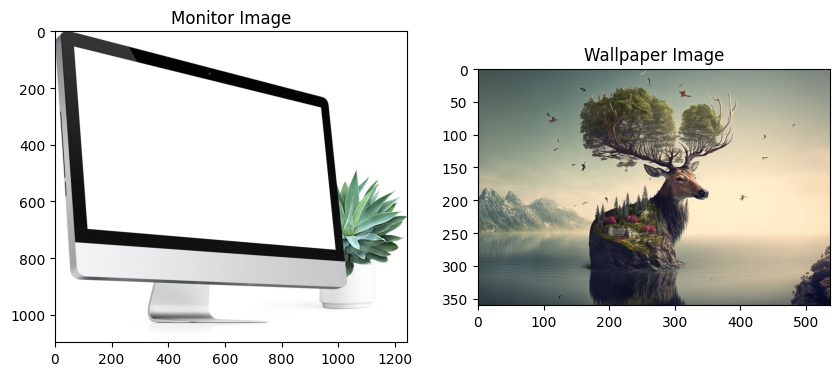

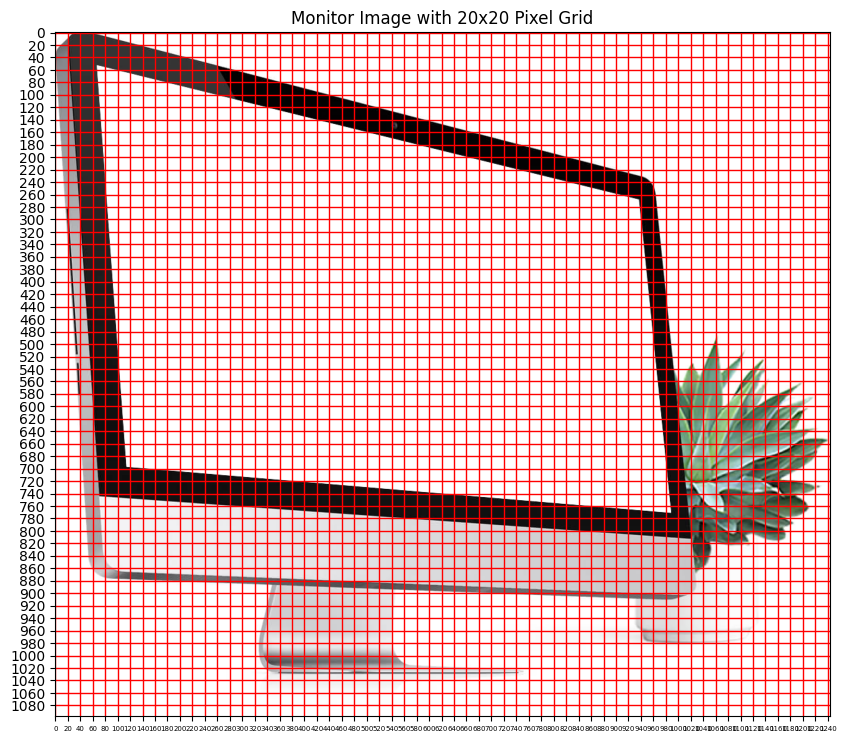

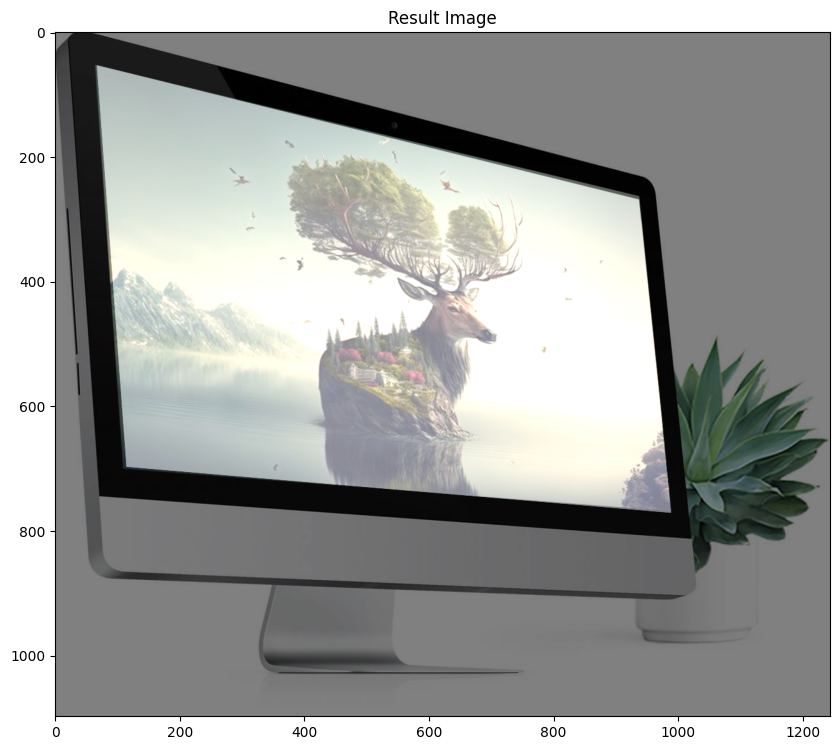

In [76]:
import cv
import numpy as np
import matplotlib.pyplot as plt

# Load the monitor image and the wallpaper image
monitor_image = cv.imread('monitor.png')
wallpaper_image = cv.imread('new_image.jpg')

# Display two images side-by-side
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(monitor_image, cv.COLOR_BGR2RGB))
plt.title('Monitor Image')
plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(wallpaper_image, cv.COLOR_BGR2RGB))
plt.title('Wallpaper Image')
plt.show()

# Display the monitor image with a 20x20 pixel grid
plt.figure(figsize=(10, 10))
plt.imshow(cv.cvtColor(monitor_image, cv.COLOR_BGR2RGB))
plt.xticks(np.arange(0, monitor_image.shape[1], 20), fontsize=5)
plt.yticks(np.arange(0, monitor_image.shape[0], 20))
plt.grid(True, color='red', linewidth=1)
plt.title('Monitor Image with 20x20 Pixel Grid')
plt.show()

# Define the four points on the monitor image that form a planar surface
# Replace these with the actual coordinates
points_on_monitor = np.array([[65, 55], [938, 265], [990, 770], [110, 702]], dtype=np.float32)

# Define the corresponding points on the wallpaper image (in the same order)
points_on_wallpaper = np.array([[0, 0], [wallpaper_image.shape[1], 0], [wallpaper_image.shape[1], wallpaper_image.shape[0]], [0, wallpaper_image.shape[0]]], dtype=np.float32)

# Compute the homography matrix
homography_matrix, _ = cv.findHomography(points_on_wallpaper, points_on_monitor)

# Warp the wallpaper image onto the monitor image using the homography
wallpaper_warped = cv.warpPerspective(wallpaper_image, homography_matrix, (monitor_image.shape[1], monitor_image.shape[0]))

# Blend the warped wallpaper image with the monitor image
result_image = cv.addWeighted(monitor_image, 0.5, wallpaper_warped, 0.7, 0)

# Display the result
plt.figure(figsize=(10, 10))
plt.imshow(cv.cvtColor(result_image, cv.COLOR_BGR2RGB))
plt.title('Result Image')
plt.show()


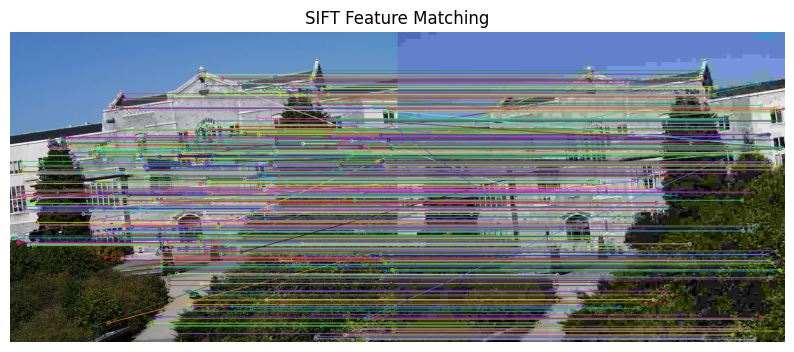

In [96]:
import cv
import numpy as np
import matplotlib.pyplot as plt

# Load the two images
img1 = cv.imread('img1.ppm', cv.IMREAD_COLOR)
img5 = cv.imread('img5.ppm', cv.IMREAD_COLOR)

# Initialize the SIFT detector
sift = cv.SIFT_create()

# Find keypoints and compute descriptors in the images
keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
keypoints5, descriptors5 = sift.detectAndCompute(img5, None)

# Initialize\a Brute Force Matcher and perform feature matching
bf = cv.BFMatcher()
matches = bf.knnMatch(descriptors1, descriptors5, k=2)

# Apply Lowe's ratio test to filter good matches
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# Draw the matches
matching_image = cv.drawMatches(img1, keypoints1, img5, keypoints5, good_matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display the matching image using matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(cv.cvtColor(matching_image, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.title('SIFT Feature Matching')
plt.show()


In [97]:
# Extract the coordinates of matched keypoints
src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([keypoints5[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

# Compute the homography using RANSAC
homography_matrix, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)

#print the homography matrix
print("Homography Matrix:")
print(homography_matrix)

Homography Matrix:
[[ 1.00099597e+00 -6.85431880e-04  3.13209320e-02]
 [ 3.54464572e-04  1.00014375e+00 -1.10532496e-01]
 [ 1.53690428e-06 -8.95294295e-07  1.00000000e+00]]


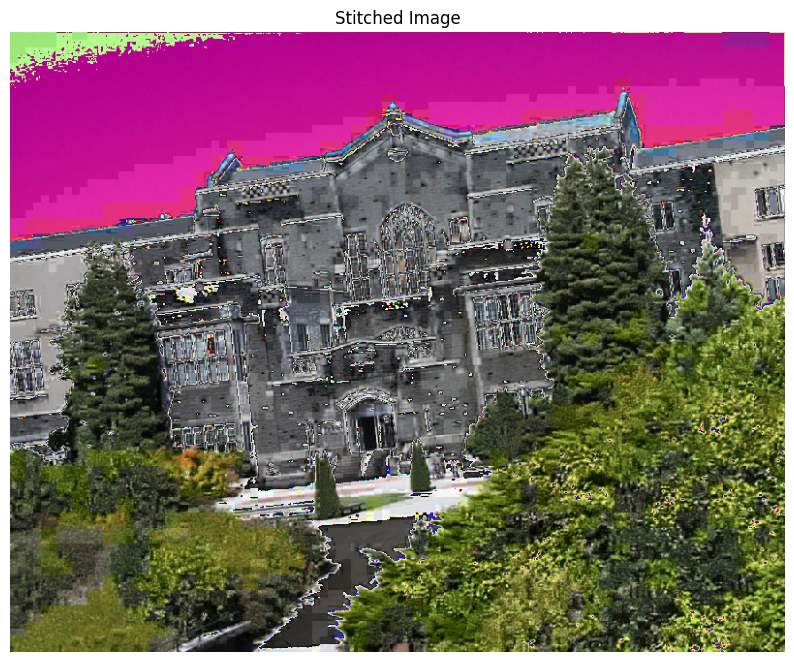

In [98]:
# Wrap 'img1.ppmm' onto 'img5.ppm' using the computed homography
stitched_image = cv.warpPerspective(img1, homography_matrix, (img5.shape[1], img5.shape[0]))

# Create a mask to combine the two images
mask = (stitched_image == 0)
stitched_image += img5
stitched_image[mask] = 0

# Convert BGR to RGB
stitched_image_rgb = cv.cvtColor(stitched_image, cv.COLOR_BGR2RGB)

# Display the stitched image
plt.figure(figsize=(10, 10))
plt.imshow(stitched_image_rgb)
plt.axis('off')
plt.title('Stitched Image')
plt.show()


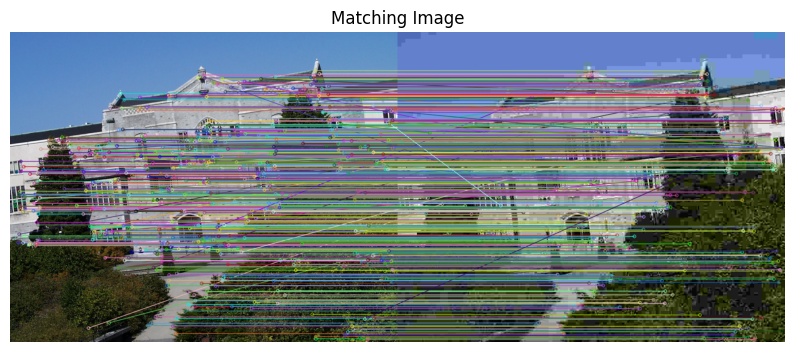

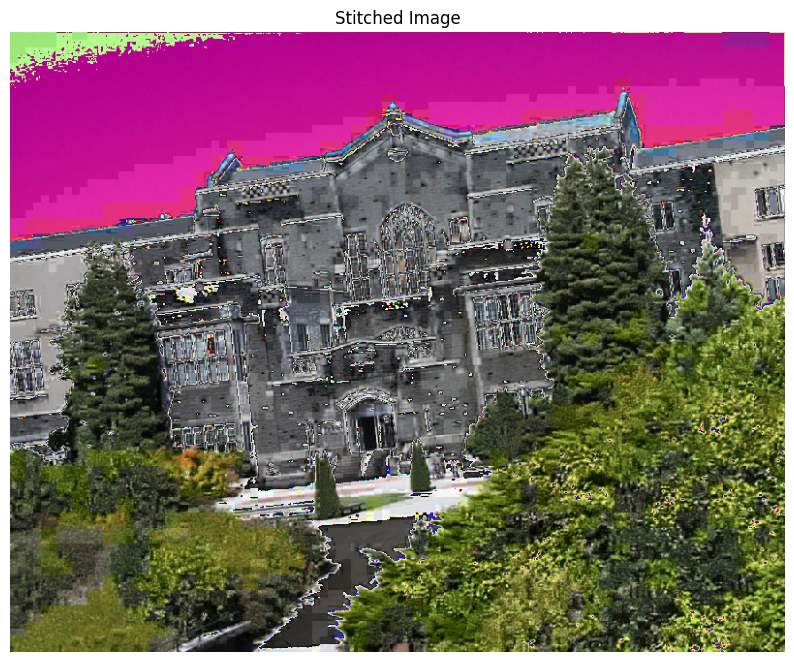

In [99]:
import cv
import numpy as np
import matplotlib.pyplot as plt

# Load the images
img1 = cv.imread('img1.ppm')
img5 = cv.imread('img5.ppm')

# Initialize the SIFT detector
sift = cv.SIFT_create()

# Find keypoints and descriptors in the images
keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
keypoints5, descriptors5 = sift.detectAndCompute(img5, None)

# Initialize the Brute Force Matcher
bf = cv.BFMatcher()

# Match the descriptors
matches = bf.knnMatch(descriptors1, descriptors5, k=2)

# Apply Lowe's ratio test to filter good matches
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# Draw the matches
matching_image = cv.drawMatches(img1, keypoints1, img5, keypoints5, good_matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display the matching image using matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(cv.cvtColor(matching_image, cv.COLOR_BGR2RGB))
plt.title('Matching Image')
plt.axis('off')
plt.show()

# Extract the coordinates of the matched keypoints
src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([keypoints5[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

# Compute the homography using RANSAC
homography_matrix, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)

# Warp `img1.ppm` onto `img5.ppm` using the computed homography
stitched_image = cv.warpPerspective(img1, homography_matrix, (img5.shape[1], img5.shape[0]))

# Create a mask to combine the two images
mask = (stitched_image == 0)
stitched_image += img5
stitched_image[mask] = 0

# Display the stitched image using matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(cv.cvtColor(stitched_image, cv.COLOR_BGR2RGB))
plt.title('Stitched Image')
plt.axis('off')
plt.show()
